<a href="https://colab.research.google.com/github/iCarrrot/nn_sudoku_project/blob/master/Raport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End of term project for Deep Learning course, SS 2020 @ University of Wrocław
Authors:
* Piotr Gdowski
* Michał Martusewicz


# Main goal
Extend the handwritten digit-recognizing network to allow verifying sudoku's solution correctness

**Before start: runtime -> change runtime type -> GPU**

In [1]:
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm


try:
    from src.net import get_test_and_train_dataloader, Net, train, test, FinalNet, get_dataloader
    from src.preprocessing import deskew_verify, Deskewing, split_into_cells
    from src.sudoku_app import get_predictions, check
    from src.util import get_gray_images, get_pics_path, present_dataset, get_pure_data
    
except ModuleNotFoundError:
    import httpimport
    with httpimport.github_repo(
            'iCarrrot', 
            'nn_sudoku_project',
            module='src',
            branch='master'
    ):
        from src.net import get_test_and_train_dataloader, Net, train, test, FinalNet, get_dataloader
        from src.preprocessing import deskew_verify, Deskewing, split_into_cells
        from src.sudoku_app import get_predictions, check
        from src.util import get_gray_images, get_pics_path, present_dataset, get_pure_data


GridInstance = namedtuple('GridInstace', 'img digits')

Populating the interactive namespace from numpy and matplotlib


# Dataset

We've collected and labeled a dataset consisting of 101 sudoku grids, which we splitted into three parts after preprocessing:
* 10 grids will be our test dataset on which we'll show how the full checker works
* ca. 5000 digits will be put to the model as a training data
* the rest will serve as verification dataset

In [2]:
# Load dataset
pics_path = get_pics_path()
gray_images, labels = get_gray_images(pics_path)
gray_images.shape

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


(101, 4160, 3120)

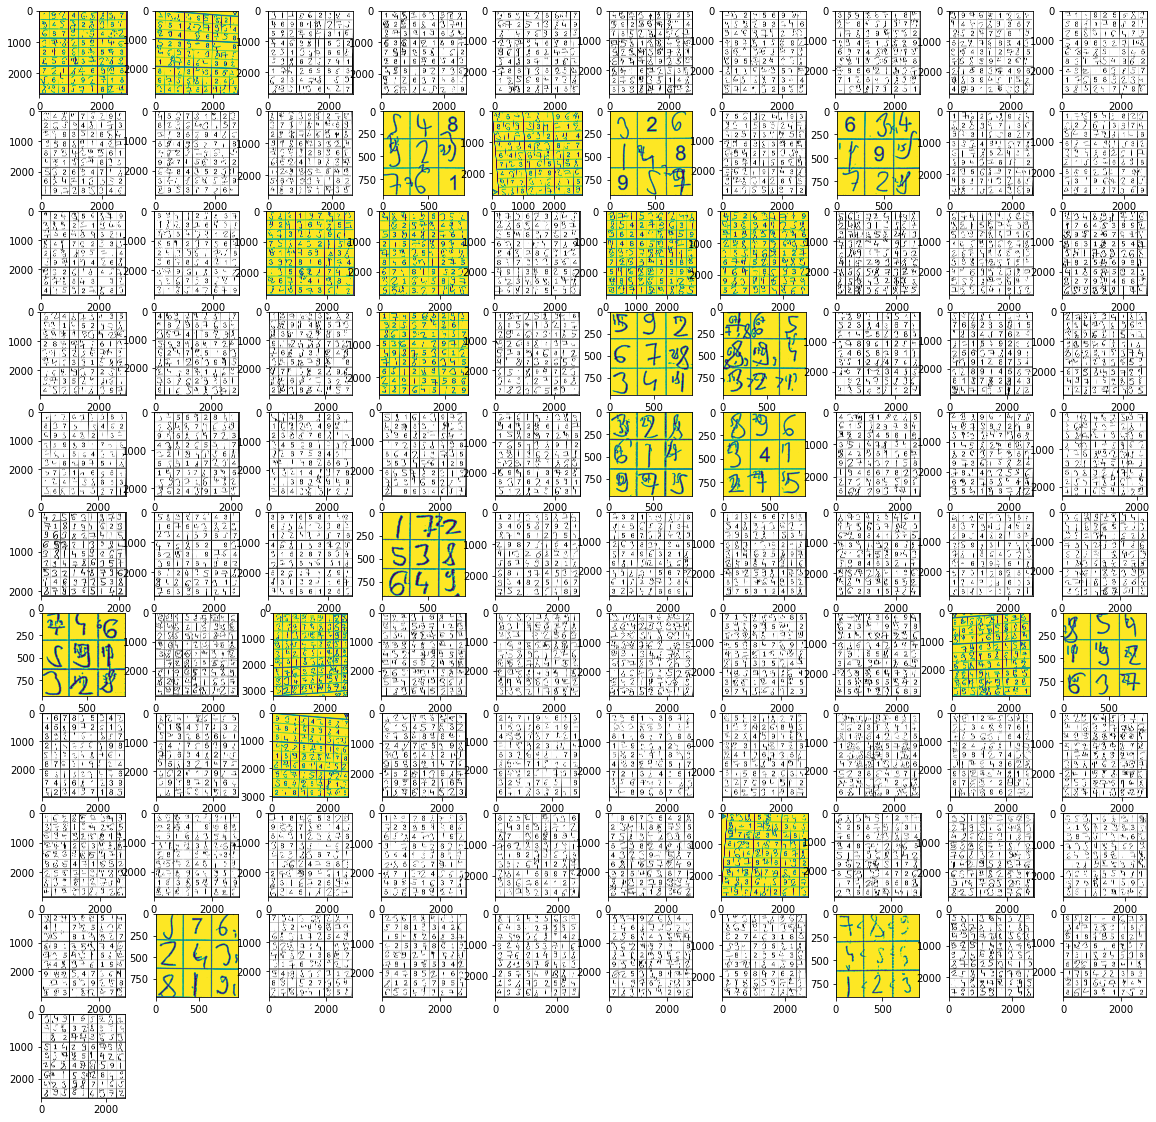

In [3]:
deskewed_imgs = []
desk_img_labels = []
plt.figure(figsize=(20, 20))
for i in tqdm(range(len(gray_images))):
    deskewed = Deskewing(gray_images[i])._deskew()
    plt.subplot(11, 10, i + 1)
    if i == 1 or not deskew_verify(deskewed):
        plt.imshow(deskewed)
    else:
        plt.imshow(deskewed, cmap='gray')
        deskewed_imgs.append(deskewed)
        desk_img_labels.append(labels[i])

## Dataset split

In [4]:
testset_ids = np.array([9,12,13,22,24,27,32,35,37,50])

testset, trainset = [], []
for i in range(len(desk_img_labels)):
    if i in testset_ids:
        testset.append(GridInstance(img=deskewed_imgs[i], digits=np.asarray(desk_img_labels[i])))
    else:
        trainset.append(GridInstance(img=deskewed_imgs[i], digits=np.asarray(desk_img_labels[i])))

print(sorted(testset_ids))

digits_labels = np.hstack([g.digits for g in trainset])
digits = np.vstack([split_into_cells(g.img) for g in trainset])
digits.shape

[9, 12, 13, 22, 24, 27, 32, 35, 37, 50]


(5427, 28, 28)

## Dataloaders and parameters

In [5]:
batch_size_train = 64
batch_size_test = 32

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('files/', train=True, download=True,
        transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])), 
    batch_size=batch_size_train, 
    shuffle=True)

grid_test_loader, grid_train_loader = get_test_and_train_dataloader(
    digits, 
    digits_labels, 
    batch_size_test = batch_size_test, 
    device='cuda')

Extracting files/MNIST/raw/train-images-idx3-ubyte.gz to files/MNIST/raw


Extracting files/MNIST/raw/train-labels-idx1-ubyte.gz to files/MNIST/raw




Extracting files/MNIST/raw/t10k-images-idx3-ubyte.gz to files/MNIST/raw


Extracting files/MNIST/raw/t10k-labels-idx1-ubyte.gz to files/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



## MNIST Dataset - sample digits and T-SNE decomposition

938it [00:12, 75.01it/s]


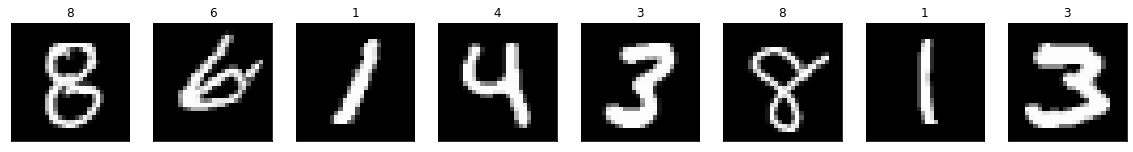

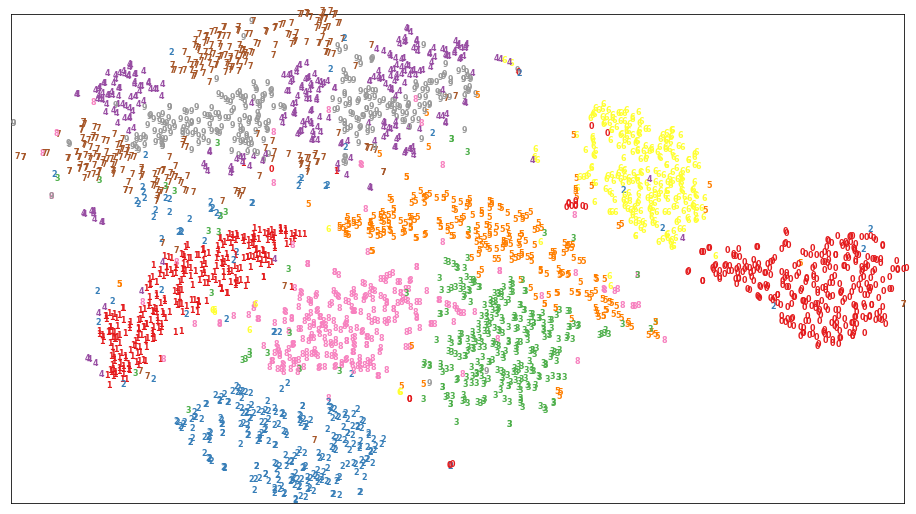

In [6]:
present_dataset(train_loader)

## Digits from sudoku grids - sample digits and T-SNE decomposition

117it [00:00, 496.95it/s]


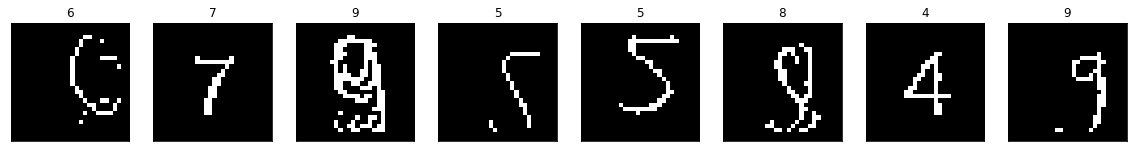

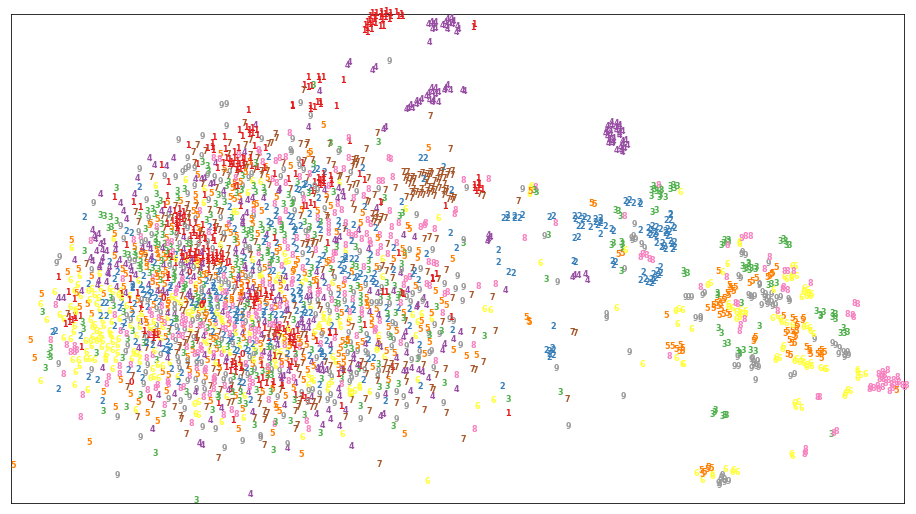

In [7]:
present_dataset(grid_train_loader)

### PCA decomposition on sudoku data

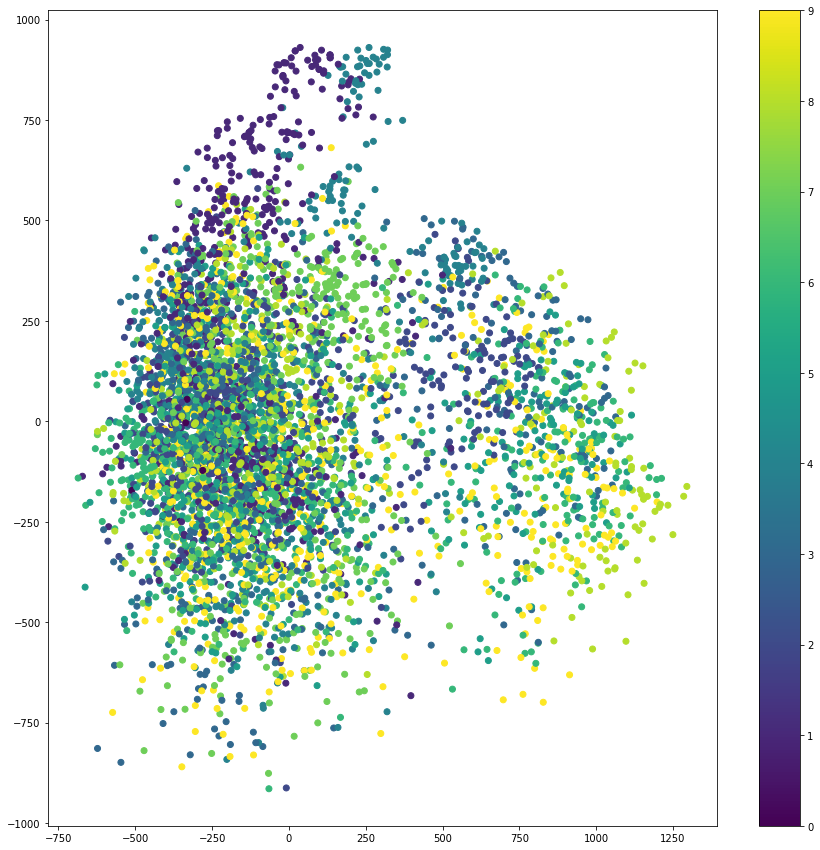

In [8]:
pca = PCA(n_components=2)
X = pca.fit_transform(digits.reshape(-1, 28*28))
X.shape
plt.figure(figsize=(15,15))
plt.scatter(X[:,0], X[:,1], c=digits_labels)
plt.colorbar()


# Classification

In this section we'll compare several approaches on classifying sudoku grids' digits.

## KNN

### 1: train on MNIST, test on sudoku_test

In [9]:
X, y = get_pure_data(train_loader)
X_test, y_test = get_pure_data(grid_test_loader)

for n_components in [10, 20, 30, 35, 40, 45, 50, 70, 100, 200]:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    pca_train = pca.transform(X)
    pca_test = pca.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(pca_train, y)

    print(f"{n_components} components: {clf.score(pca_test, y_test)}")

938it [00:12, 72.26it/s]
54it [00:00, 1779.92it/s]


10 components: 0.11581422692533803
20 components: 0.18694885361552027
30 components: 0.2139917695473251
35 components: 0.23339212228101117
40 components: 0.2328042328042328
45 components: 0.24691358024691357
50 components: 0.23985890652557318
70 components: 0.25220458553791886
100 components: 0.24279835390946503
200 components: 0.25044091710758376


### 2: train on PCA(sudoku_train), test on PCA(sudoku_test)

In [10]:
X, y = get_pure_data(grid_train_loader)
X_test, y_test = get_pure_data(grid_test_loader)

for n_components in [10, 20, 30, 35, 40, 45, 50, 70, 100, 200]:
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    pca_train = pca.transform(X)
    pca_test = pca.transform(X_test)
    
    clf = KNeighborsClassifier()
    clf.fit(pca_train, y)

    print(f"{n_components} components: {clf.score(pca_test, y_test)}")

117it [00:00, 1798.89it/s]
54it [00:00, 1901.56it/s]


10 components: 0.6372721928277484
20 components: 0.7084068195179306
30 components: 0.7283950617283951
35 components: 0.733098177542622
40 components: 0.7366255144032922
45 components: 0.7301587301587301
50 components: 0.7125220458553791
70 components: 0.6878306878306878
100 components: 0.6502057613168725
200 components: 0.562610229276896


## NN

### Simple NN on different datasets

In [11]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=train_loader, title="Train on mnist dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on mnist dataset
Train, Epoch: 1/1 [0/60000 (0%)]	Loss: 2.305088
Train, Epoch: 1/1 [6400/60000 (11%)]	Loss: 0.382873
Train, Epoch: 1/1 [12800/60000 (21%)]	Loss: 0.441467
Train, Epoch: 1/1 [19200/60000 (32%)]	Loss: 0.168788
Train, Epoch: 1/1 [25600/60000 (43%)]	Loss: 0.101751
Train, Epoch: 1/1 [32000/60000 (53%)]	Loss: 0.122463
Train, Epoch: 1/1 [38400/60000 (64%)]	Loss: 0.159899
Train, Epoch: 1/1 [44800/60000 (75%)]	Loss: 0.144778
Train, Epoch: 1/1 [51200/60000 (85%)]	Loss: 0.202027
Train, Epoch: 1/1 [57600/60000 (96%)]	Loss: 0.110841

Test set: Average loss: 114.5187, Accuracy: 970/1701 (57%)



In [12]:
model = Net()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)

Train on own dataset
Train, Epoch: 1/1 [0/3726 (0%)]	Loss: 12.300898
Train, Epoch: 1/1 [3200/3726 (85%)]	Loss: 1.591181

Test set: Average loss: 0.6704, Accuracy: 1340/1701 (79%)



### Final Net

In [ ]:
model = FinalNet()
model.to('cuda')
train(model=model, device='cuda', train_loader=grid_train_loader, epoch=60, title="Train on own dataset", optimizer=torch.optim.Adam(model.parameters()))
prediction = test(model=model, device='cuda', test_loader=grid_test_loader)
torch.save(model.state_dict(), 'drive/My Drive/dataset/final_net.nn')

### Reload final net

In [13]:
restored_model = FinalNet()
restored_model.load_state_dict(torch.load('drive/My Drive/dataset/final_net.nn'))
restored_model.cuda()
prediction = test(model=restored_model, device='cuda', test_loader=grid_test_loader)


Test set: Average loss: 0.5472, Accuracy: 1575/1701 (93%)



# Real life application

Given a sudoku grid, find errors or say it's fine

In [14]:
img, y = testset[4]
grid_cells = split_into_cells(img)
nonempty_cells = []
for idx, cell in enumerate(grid_cells):
    nonempty_cells.append(idx)

grid_dataloader = get_dataloader(grid_cells[nonempty_cells], y[nonempty_cells])

predicted, ppbs = get_predictions(restored_model, 'cuda', grid_dataloader)


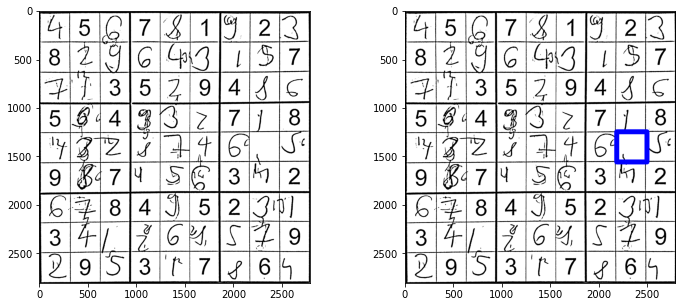

[[1 7 6 2 3 8 9 5 4]
 [5 2 8 9 4 7 1 3 6]
 [9 1 3 1 6 5 8 2 7]
 [3 5 2 4 9 1 6 7 8]
 [6 1 7 8 5 2 4 9 2]
 [8 9 4 3 7 6 5 1 2]
 [2 3 5 6 8 9 7 4 1]
 [4 6 9 7 1 9 2 8 5]
 [7 8 1 5 2 4 9 6 9]]
[(8, 8), (8, 6)] [1. 1.]
[(7, 5), (7, 2)] [1. 1.]
[(7, 5), (6, 5)] [1. 1.]
[(5, 8), (4, 8)] [1. 1.]
[(4, 8), (4, 5)] [1. 1.]
[(8, 6), (0, 6)] [1. 1.]


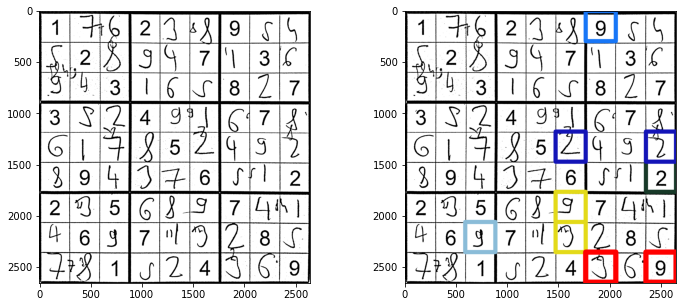

[[1 7 6 5 4 9 8 2 3]
 [5 2 8 6 1 3 9 7 4]
 [9 4 3 7 2 8 1 9 6]
 [6 8 7 4 9 1 9 3 2]
 [3 9 4 8 5 2 6 1 7]
 [2 1 5 3 7 6 8 9 8]
 [8 5 9 2 3 5 7 4 1]
 [7 3 1 9 6 4 2 8 5]
 [4 5 2 1 8 2 9 6 9]]
[(5, 8), (5, 6)] [1. 1.]
[(5, 6), (0, 6)] [1. 1.]
[(5, 7), (2, 7)] [1.         0.99996376]
[(2, 7), (2, 0)] [0.99996376 1.        ]
[(2, 7), (1, 6)] [0.99996376 1.        ]
[(5, 7), (3, 6)] [1.         0.99925643]
[(3, 6), (3, 4)] [0.99925643 1.        ]
[(3, 6), (1, 6)] [0.99925643 1.        ]
[(8, 5), (8, 2)] [0.99806166 1.        ]
[(8, 5), (6, 3)] [0.99806166 1.        ]
[(8, 5), (4, 5)] [0.99806166 1.        ]


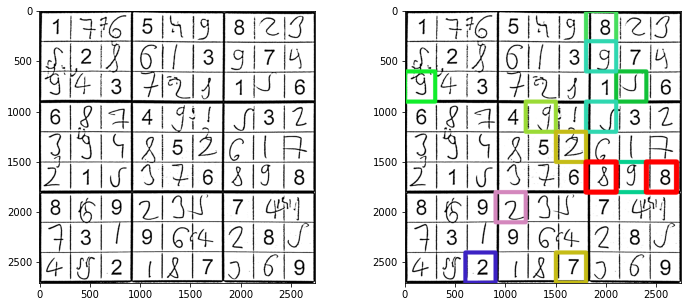

[[1 9 7 6 9 3 8 8 2]
 [6 2 9 1 4 8 5 7 3]
 [8 3 1 7 2 8 9 6 1]
 [9 1 2 4 8 6 7 3 5]
 [7 6 8 5 3 1 2 4 9]
 [3 4 5 2 7 9 6 1 8]
 [3 7 1 3 6 2 8 9 6]
 [5 8 6 4 1 7 3 2 4]
 [2 2 3 8 6 4 1 5 7]]
[(1, 2), (0, 1)] [1.         0.99977493]
[(0, 4), (0, 1)] [0.9999981  0.99977493]
[(2, 5), (2, 0)] [0.9979898 1.       ]
[(2, 5), (1, 5)] [0.9979898 1.       ]
[(0, 7), (0, 6)] [1.         0.98477817]
[(6, 6), (0, 6)] [1.         0.98477817]


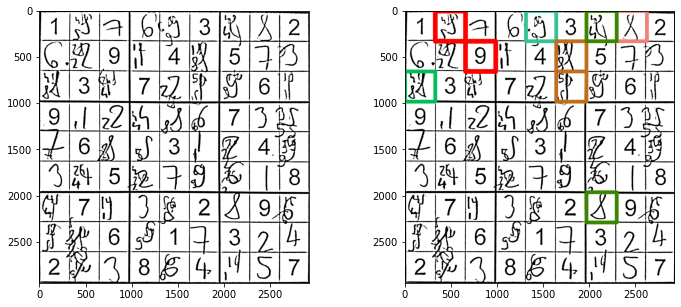

[[9 8 9 3 1 6 5 4 3]
 [5 2 3 8 4 8 6 7 8]
 [6 1 4 7 5 2 3 8 9]
 [3 7 8 9 6 1 2 5 4]
 [2 4 6 5 8 7 9 1 3]
 [9 5 1 2 8 4 7 6 8]
 [8 6 7 1 2 3 4 9 5]
 [1 9 2 4 7 5 8 9 5]
 [4 3 5 6 9 8 1 2 7]]
[(5, 8), (5, 4)] [1. 1.]
[(5, 4), (4, 4)] [1. 1.]
[(7, 7), (7, 1)] [1. 1.]
[(7, 7), (6, 7)] [1.        0.9997235]
[(1, 8), (1, 3)] [0.9996062 1.       ]
[(2, 7), (1, 8)] [1.        0.9996062]
[(5, 8), (1, 8)] [1.        0.9996062]
[(0, 2), (0, 0)] [1.        0.9976848]
[(5, 0), (0, 0)] [1.        0.9976848]
[(7, 8), (7, 5)] [0.99613655 1.        ]
[(7, 8), (6, 8)] [0.99613655 1.        ]
[(2, 6), (0, 8)] [1.        0.9879962]
[(4, 8), (0, 8)] [1.        0.9879962]
[(0, 8), (0, 3)] [0.9879962 1.       ]


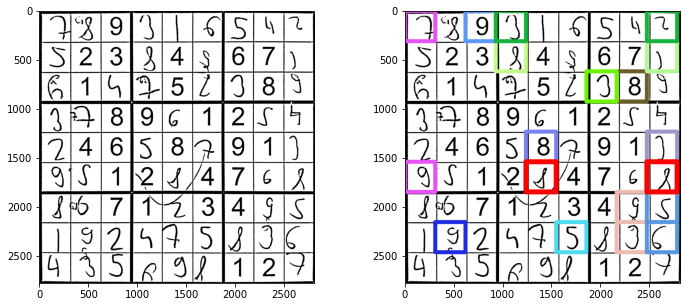

[[4 1 2 6 7 8 9 8 5]
 [8 3 7 9 1 5 4 6 2]
 [4 9 5 4 8 2 1 3 7]
 [2 9 9 8 3 1 7 4 6]
 [7 8 1 5 6 4 3 2 8]
 [3 4 6 2 9 7 5 1 8]
 [9 7 3 1 4 6 6 5 4]
 [1 2 4 7 5 8 6 9 3]
 [5 6 8 3 4 9 2 7 1]]
[(7, 6), (6, 6)] [1.        0.9999914]
[(6, 6), (6, 5)] [0.9999914 1.       ]
[(2, 3), (2, 0)] [1.         0.99963576]
[(2, 0), (0, 0)] [0.99963576 0.99944514]
[(8, 4), (6, 4)] [1.        0.9972068]
[(6, 8), (6, 4)] [1.        0.9972068]


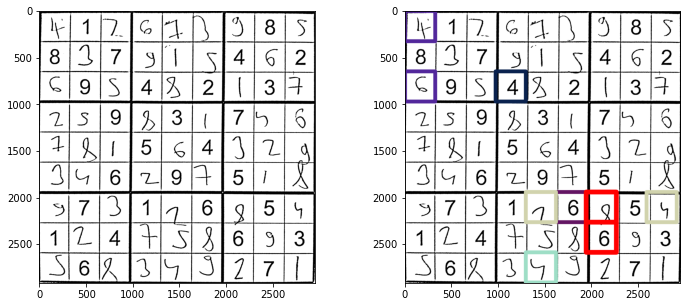

[[4 3 9 9 1 6 2 8 5]
 [6 1 5 1 2 4 7 3 4]
 [7 8 2 3 4 5 6 1 9]
 [3 5 1 6 7 8 9 4 2]
 [8 4 2 9 5 1 9 6 7]
 [9 2 7 4 3 2 1 5 8]
 [1 9 4 5 6 7 8 2 3]
 [2 7 3 1 8 4 5 9 6]
 [5 6 8 2 9 3 1 4 1]]
[(5, 5), (5, 1)] [1. 1.]
[(5, 1), (4, 2)] [1. 1.]
[(4, 2), (2, 2)] [1. 1.]
[(8, 7), (3, 7)] [0.99995995 1.        ]
[(2, 4), (1, 5)] [1.         0.99971014]
[(1, 8), (1, 5)] [0.99998474 0.99971014]
[(7, 5), (1, 5)] [1.         0.99971014]
[(4, 3), (0, 3)] [1.         0.99969965]
[(8, 8), (8, 6)] [1.         0.99969584]
[(8, 6), (5, 6)] [0.99969584 1.        ]
[(7, 3), (1, 3)] [0.99759865 0.9893436 ]
[(1, 3), (1, 1)] [0.9893436 1.       ]
[(1, 3), (0, 4)] [0.9893436 1.       ]
[(4, 6), (4, 3)] [0.95026994 1.        ]
[(4, 6), (3, 6)] [0.95026994 0.99960524]


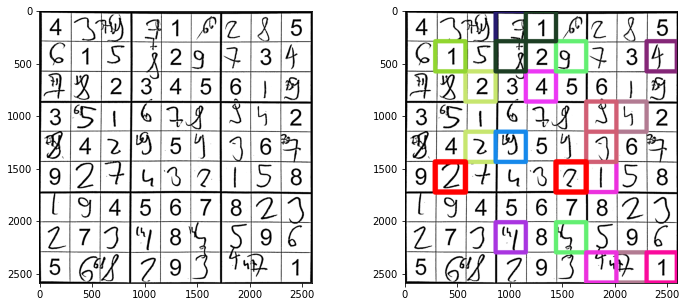

[[4 2 5 6 3 8 8 7 9]
 [5 1 8 5 9 4 6 2 3]
 [9 6 3 8 2 7 4 4 5]
 [6 5 7 2 1 3 9 8 4]
 [3 8 1 4 5 9 2 6 7]
 [2 9 4 7 8 6 3 5 7]
 [5 3 2 1 4 8 7 9 6]
 [1 4 6 9 7 2 5 3 8]
 [8 7 9 3 6 5 1 4 2]]
[(6, 0), (1, 0)] [1.         0.99999523]
[(1, 3), (1, 0)] [0.9999981  0.99999523]
[(1, 0), (0, 2)] [0.99999523 1.        ]
[(2, 3), (0, 5)] [1.        0.9909286]
[(6, 5), (0, 5)] [1.        0.9909286]
[(0, 6), (0, 5)] [0.98033005 0.9909286 ]
[(8, 7), (2, 7)] [1.         0.96961415]
[(2, 7), (2, 6)] [0.96961415 1.        ]
[(5, 8), (5, 3)] [0.96073085 1.        ]


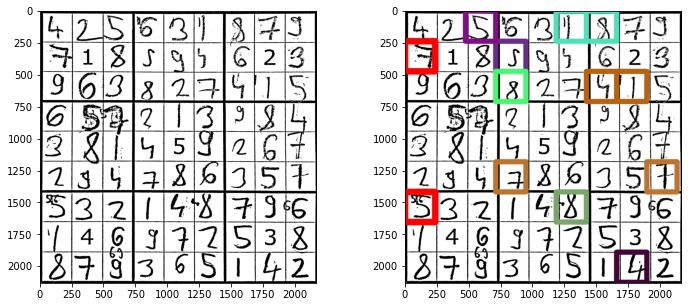

[[3 9 7 6 5 8 1 4 2]
 [6 5 4 7 1 2 3 8 9]
 [1 8 2 4 3 1 5 7 6]
 [4 6 8 1 9 3 7 2 5]
 [9 1 5 2 8 7 6 3 4]
 [2 7 3 5 4 6 1 1 8]
 [5 2 6 5 7 4 8 9 1]
 [8 3 1 9 2 5 4 6 7]
 [7 4 9 8 6 1 2 5 3]]
[(5, 7), (5, 6)] [1.         0.99971205]
[(5, 6), (0, 6)] [0.99971205 1.        ]


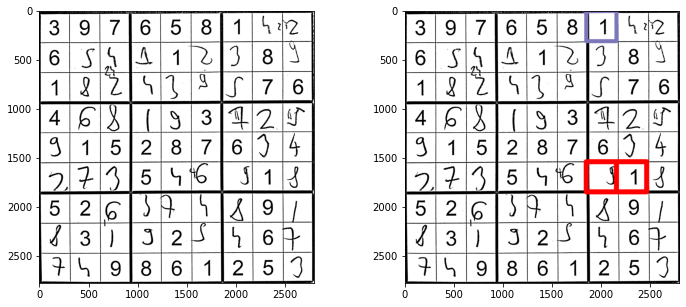

[[1 6 7 8 5 5 9 4 2]
 [4 5 2 9 7 2 6 1 3]
 [3 9 2 1 6 4 8 5 7]
 [2 1 4 7 5 6 3 9 8]
 [5 3 9 2 4 8 7 6 1]
 [8 7 6 3 1 9 6 2 4]
 [9 8 1 5 2 8 4 7 6]
 [7 4 5 6 8 1 2 3 9]
 [8 2 3 4 9 7 1 8 5]]
[(0, 5), (0, 4)] [1.         0.99767476]
[(3, 4), (0, 4)] [1.         0.99767476]
[(1, 5), (1, 2)] [1.         0.94034976]
[(2, 2), (1, 2)] [1.         0.94034976]
[(8, 7), (8, 0)] [1.         0.93294203]
[(8, 0), (6, 1)] [0.93294203 0.9780739 ]
[(8, 0), (5, 0)] [0.93294203 1.        ]


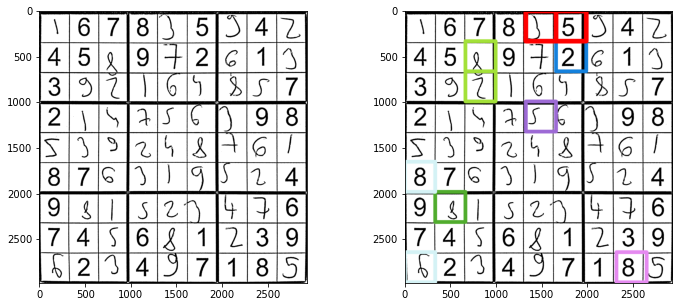

In [15]:
for gi in testset:
    check(gi, restored_model, 0.95)

# What have we learnt
* Colab sucks
* MNIST didn’t help
* Graphic card has limited memory

# Further work

* Collect more labeled data -> different handwriting styles
* Improve data preprocessing
* Better net architecture
* Release as mobile app
* Different approach?
    * Train neural net with the whole sudoku diagram